# Visualizing predictions

We visualize here a single stay's monitor augmented with predictions.

In [8]:
import os
import re
import pickle
import pandas
import numpy
import matplotlib.pyplot as plt
%matplotlib inline
try:
    import ipywidgets
except Exception as e:
    print("cannot import ipywidgets: {}".format(e))
    ipywidgets = None
pandas.options.mode.chained_assignment = None 

CONCEPTS = ["HR", "InvBPDias", "InvBPSys", "SpO2",
            "Temperature monitor", "Central Venous Pressure",
            "RRtotal"]

Let's choose a stay and prediction model to visualize.

In [9]:
DEPTH = 5
DELAY = 1

# MODELS = ["ALL", "HR,SpO2,InvBPDias,InvBPSys"]
MODELS = ["ALL"]
ARCHS = ["rnn-128-3"]

if ipywidgets:
    @ipywidgets.interact
    def choose_stay(stayid="Ichilov_MICU_20440"):
        global STAYID
        STAYID = stayid.strip()

    @ipywidgets.interact
    def choose_model(model=MODELS):
        global MODEL
        MODEL = model
        
    @ipywidgets.interact
    def choose_arch(arch=ARCHS):
        global ARCH
        ARCH = arch

else:
    STAYID = STAYIDS[0]
    MODEL = MODELS[0]
    ARCH = ARCHS[0]

interactive(children=(Text(value='Ichilov_MICU_20440', description='stayid'), Output()), _dom_classes=('widget-interact',))

interactive(children=(Dropdown(description='model', options=('ALL',), value='ALL'), Output()), _dom_classes=('widget-interact',))

interactive(children=(Dropdown(description='arch', options=('rnn-128-3',), value='rnn-128-3'), Output()), _dom_classes=('widget-interact',))

In [10]:
STAY = "../data/monitor-dataset-{}-predict-{}-{}:{}-{}.pkl".format(STAYID, MODEL, DEPTH, DELAY, ARCH)
with open(STAY, "rb") as f:
    df = pickle.load(f)
# You can cut off a region of the dataframe like this:
# df = df[1*len(df)//2:3*len(df)//4]

For each concept we show two plots side by side. 
* On the left-hand plot the confidence intervals are shown (in pale orange). The  actual measurements are in blue.
* The right-hand plot shows negative log-likelihood (NLL) of predictions, averaged over a rolling window. The orange is the NLL. NLL should jump on low-confidence regions, corresponding to high variability or trend change. The pale blue background shows actual measurements, shifted two zero mean and scaled for easier comparison with NLL.

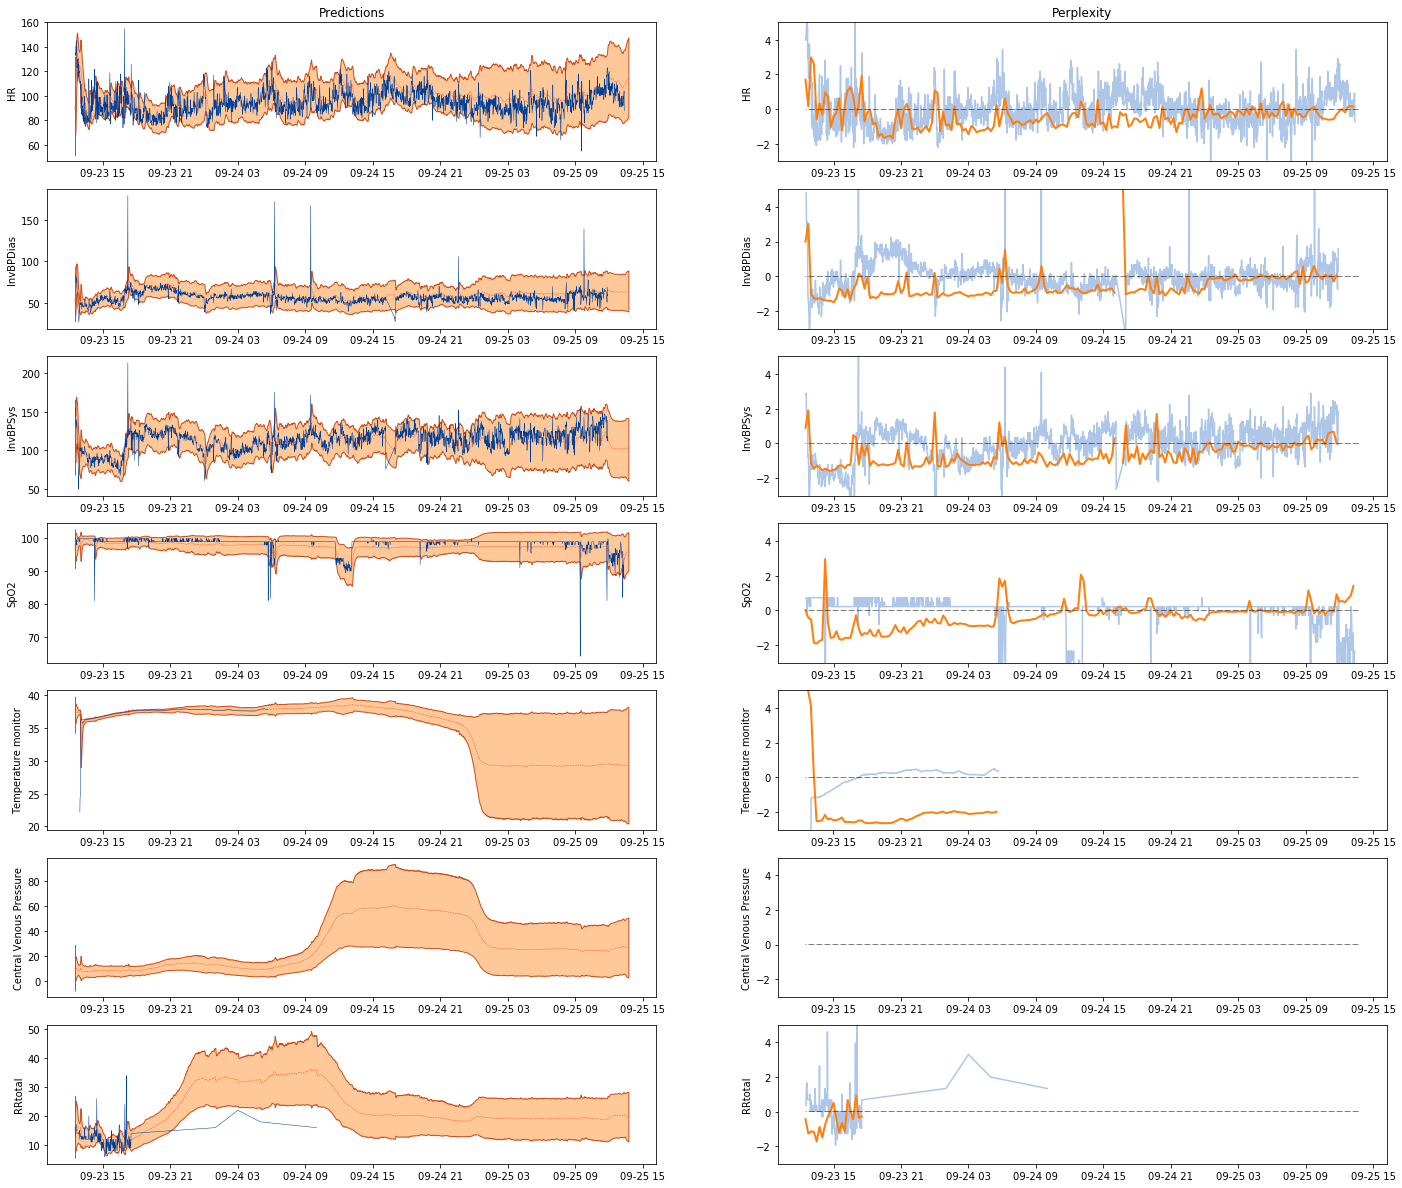

In [11]:
WINDOW = '15min'

MAX_NLL = 5 
MIN_NLL = -3

def cutoff(nll):
    """Cutoffs extreme NLL values for better presentation
    """
    shift = (MAX_NLL + MIN_NLL)/2
    scale = (MAX_NLL - MIN_NLL)/2
    return scale*numpy.tanh((nll - shift)/scale) + shift

def scale(concept):
    """Scales concept to display with NLL
    """
    return (concept - concept.mean())/concept.std()

concepts = [c for c in CONCEPTS if c + "_mean" in set(df.columns)]
fig, sps = plt.subplots(len(concepts), 2)
fig.set_figwidth(24)
fig.set_figheight(3*len(concepts))
for i, c in enumerate(concepts):
    avail = numpy.logical_not(numpy.isnan(df[c]))
    
    # Concept prediction
    mean = df[c + "_mean"]
    std = df[c + "_std"]
    sps[i, 0].fill_between(df.index, mean - 2 * std, mean + 2 *std,
                         edgecolor='#CC4F1B', facecolor='#FFC898')
    sps[i, 0].plot(mean, '--', lw=0.5, c='#FF4F1B')
    sps[i, 0].plot(df[c][avail], c='#003F99', lw=0.5)
    sps[i, 0].set_ylabel(c)
    
    # Concept perplexity
    zero = df[c].copy()
    zero[:] = 0.
    sps[i, 1].plot(scale(df[c][avail]), c='#AEC7E8')
    sps[i, 1].plot(cutoff(df[c + "_nll"][avail]).resample(rule=WINDOW).mean(), c='#FF7F0E', lw=2)
    sps[i, 1].plot(zero, c='black', linestyle=(-6, [12, 4]), lw=0.5)
    sps[i, 1].set_ylim((MIN_NLL, MAX_NLL))
    
    sps[i, 1].set_ylabel(c)

sps[0, 0].set_title("Predictions")
sps[0, 1].set_title("Perplexity")